# Medical Abstract Categorization

This dataset comes from Kaggle at "https://www.kaggle.com/datasets/chaitanyakck/medical-text/data" and provides data that can be used to determine the class of medical problem describes in the abstract. Medical abstracts describe the condition of the patient. These abstracts are read by doctors on a routine basis. The goal is to create an assistive technology that can identify the class of problem.

The dataset has the following features.

- Label: The class of medical problem represented as an integer. These map to the following classes of issues 
    - digestive system diseases
    - cardiovascular diseases
    - neoplasms
    - nervous system diseases
    - general pathological conditions
- Abstract: The text contents in the abstract. 

In [14]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import string
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import NMF

path = "./train.dat"
df = pd.read_csv(path, sep="\t", names=["label", "abstract"])

## EDA

### Inspection

We can start off by just inspecting the dataframe and see if anything needs cleaning or needs to be imputed.

In [3]:
print("----- Dataframe Info -----")
print(df.info())
print("\n----- Null counts -----")
null_counts = df.isna().sum()
print(null_counts)

----- Dataframe Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14438 entries, 0 to 14437
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     14438 non-null  int64 
 1   abstract  14438 non-null  object
dtypes: int64(1), object(1)
memory usage: 225.7+ KB
None

----- Null counts -----
label       0
abstract    0
dtype: int64


Looks like we have a fairly large dataset of 14438 rows of data with no null counts. We can move on to look at the distribution of our features. In this case number of abstracts per label type.

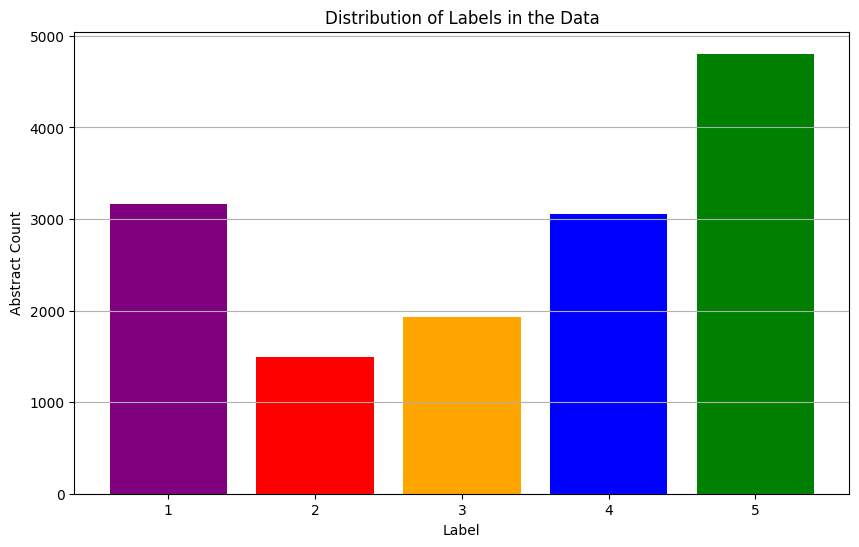

In [4]:
labels, counts = zip(*Counter(df["label"]).items())
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=["blue", "green", "red", "purple", "orange"])
plt.xlabel("Label")
plt.ylabel("Abstract Count")
plt.title("Distribution of Labels in the Data")
plt.xticks(labels)
plt.grid(axis='y')
plt.show()

Our distribution of data is unbalanced which could have unintended consequences later when we train our models as the prediction may be weighted towards a particular label. Best to keep this in mind for now.

Given we are dealing with textual abstracts and their associated labels. It may give us valuable insight to look at the frequency of words in each label and potentially remove words with little value. 

First lets look at word frequency in the entire dataframe first. We are going to exclude common words such as "and", "the", "is", "in", and other such common words that appear frequently in the English language. 

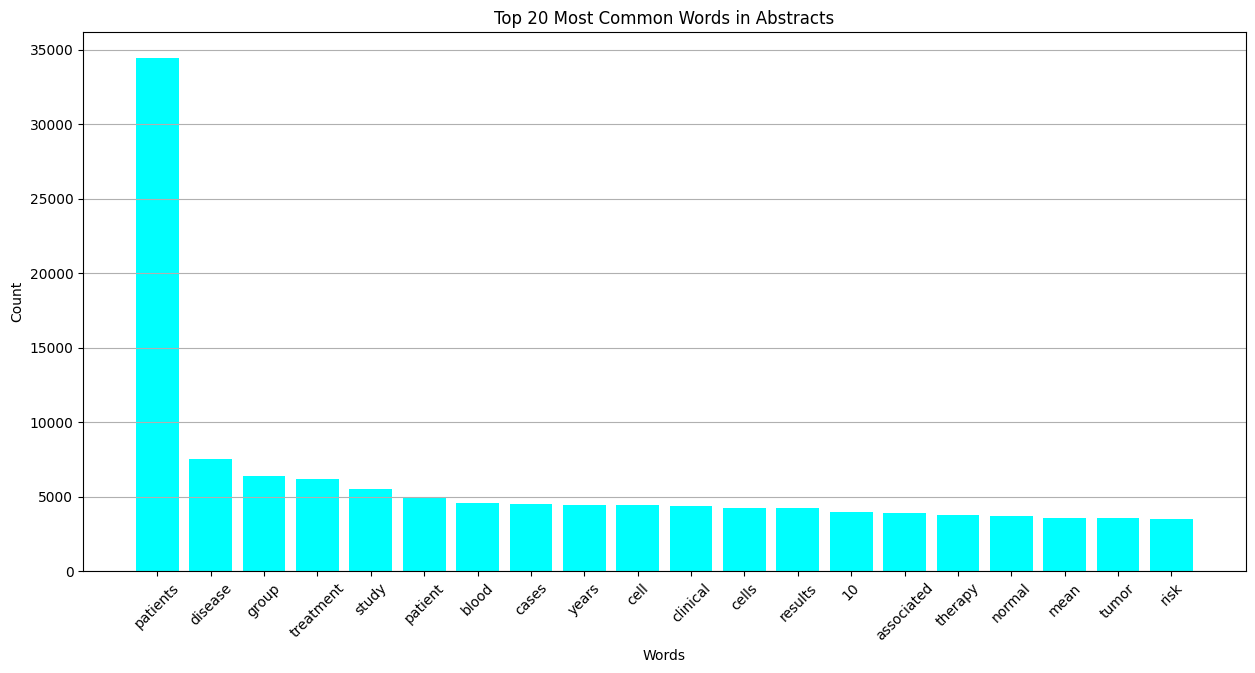

In [5]:
MAX_FEATURES = 20

vectorizer = CountVectorizer(stop_words="english", max_features=MAX_FEATURES)
X = vectorizer.fit_transform(df["abstract"])
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

words, frequencies = zip(*words_freq)

plt.figure(figsize=(15, 7))
plt.bar(words, frequencies, color="cyan")
plt.xlabel("Words")
plt.ylabel("Count")
plt.title(f"Top {MAX_FEATURES} Most Common Words in Abstracts")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

So far it seems we can filter words that appears more than 5000 times as 'patients' for example would add little benefit. Before making that filter though lets see what the frequency of words in each label are.

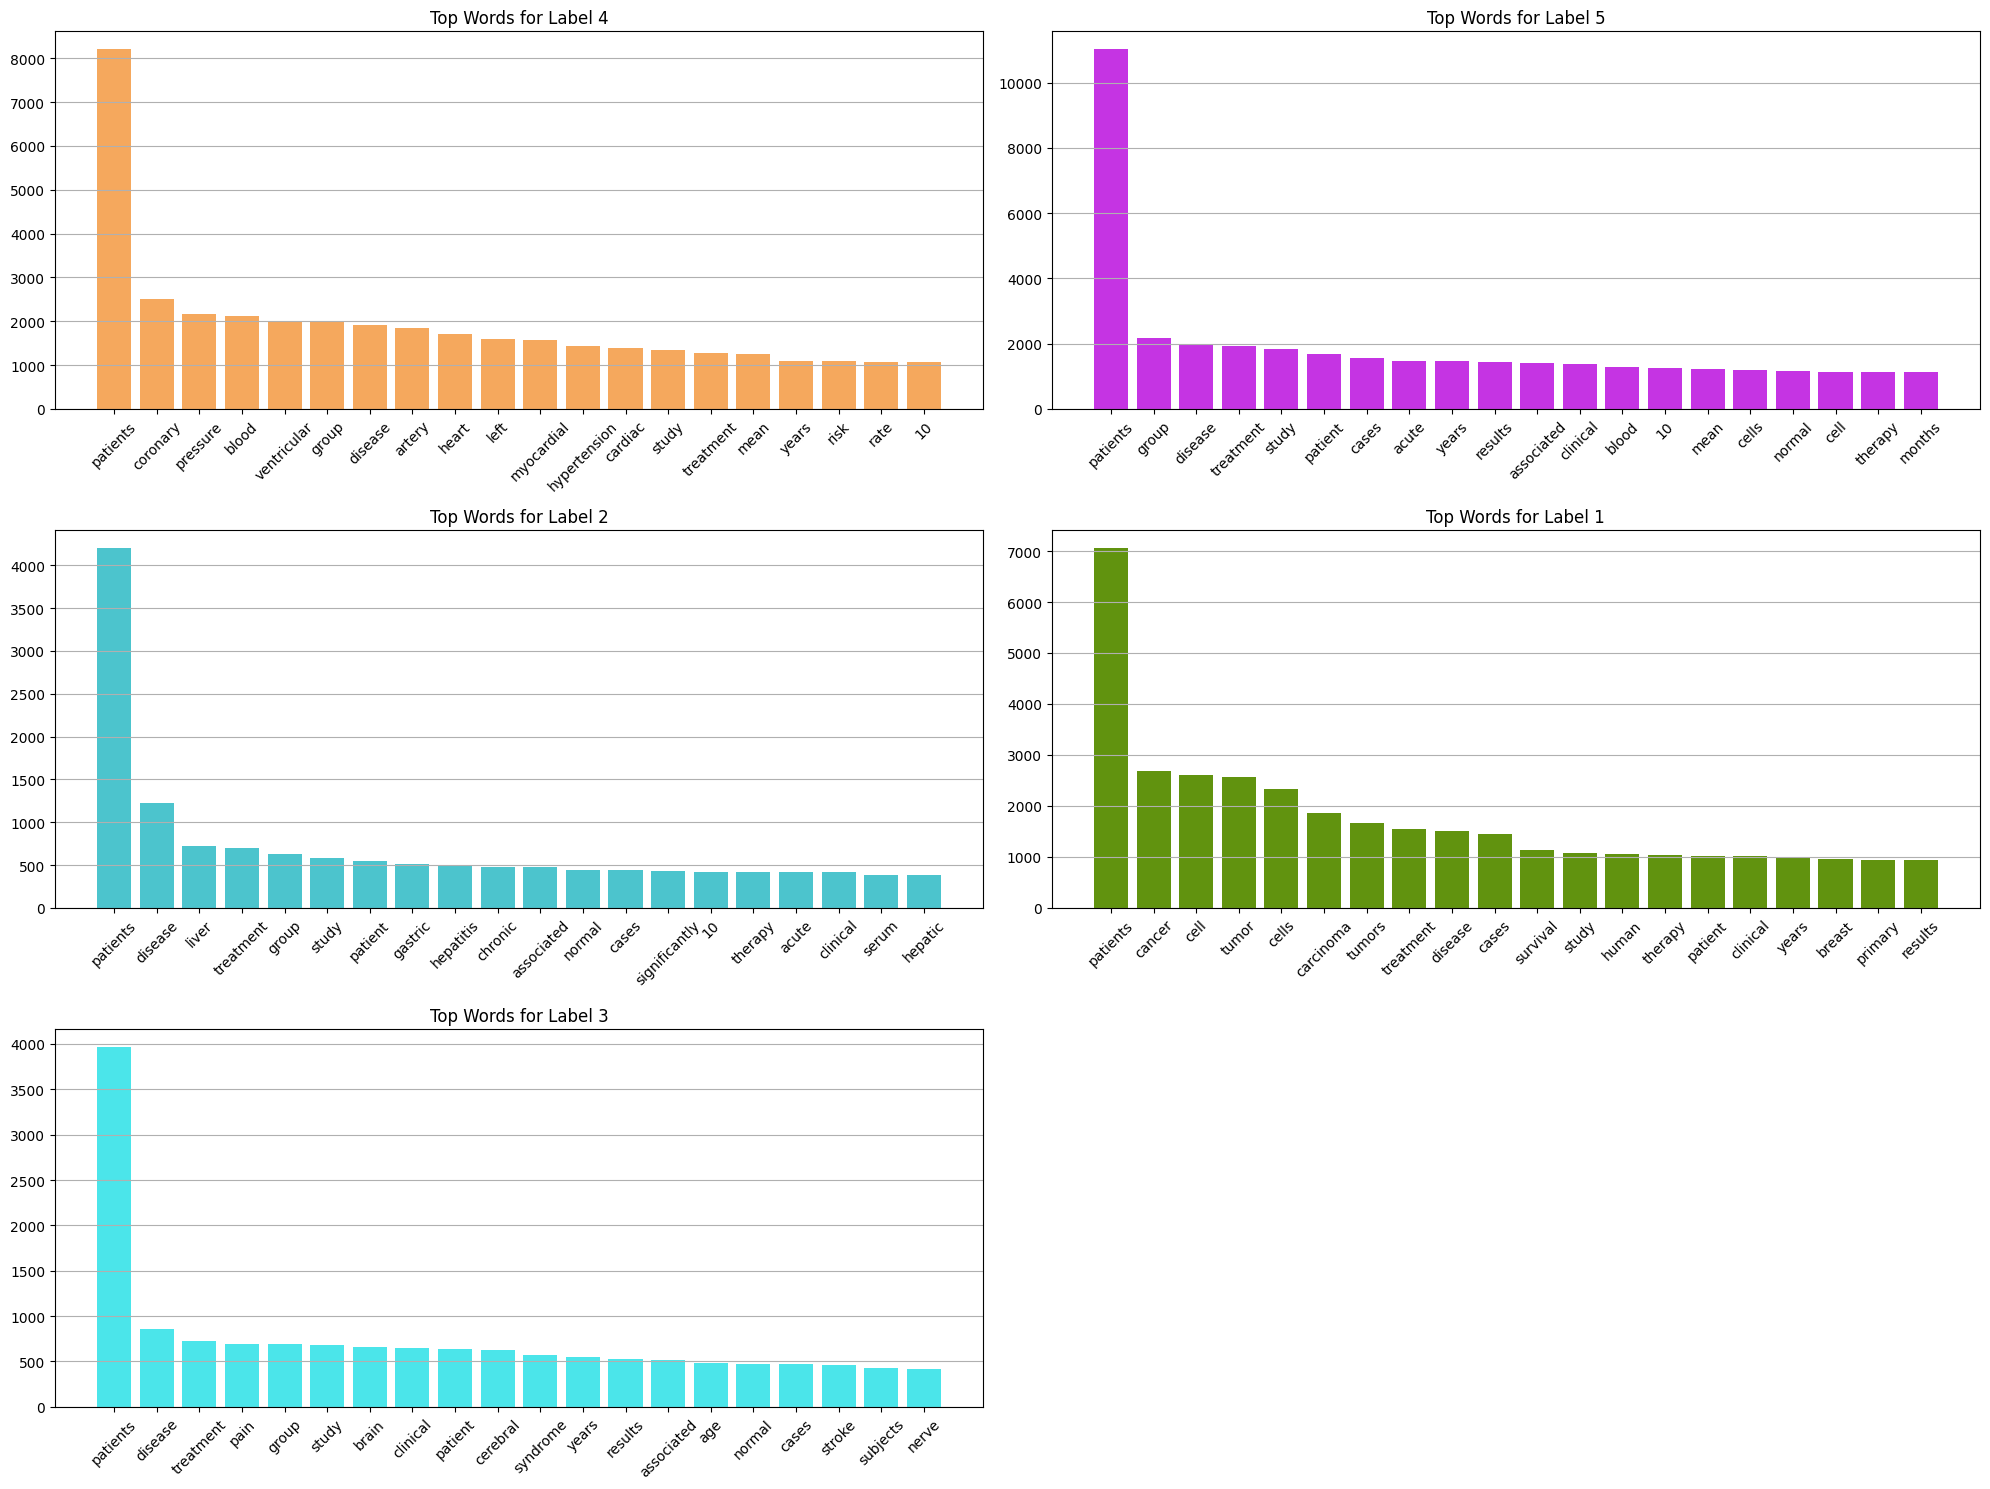

In [6]:
def get_top_words_for_label(label, n=MAX_FEATURES):
    abstracts_for_label = df[df["label"] == label]["abstract"]
    vectorizer = CountVectorizer(stop_words="english", max_features=n)
    X = vectorizer.fit_transform(abstracts_for_label)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)

plt.figure(figsize=(20, 15))
for i, label in enumerate(df["label"].unique(), 1):
    words_freq = get_top_words_for_label(label)
    words, frequencies = zip(*words_freq)
    plt.subplot(3, 2, i)
    plt.bar(words, frequencies, color=np.random.rand(3,))
    plt.title(f"Top Words for Label {label}")
    plt.xticks(rotation=45)
    plt.grid(axis="y")

plt.tight_layout()
plt.show()

I would of expected to see the same common words for each label but that does not seem to be the case. Yet, the word 'patients' seems to be the only word that makes sense to filter out at this point as it appears in large frequency in each label and thus has no value in label prediction or categorization.

In [7]:
df["abstract"] = df["abstract"].str.replace(r'\bpatients\b', '', regex=True)

### Text Pre-processing

Regardless of model type text preprocessing is a fundamental step in natural language processing (NLP). Raw text data is inherently noisy and unstructured, so preprocessing helps to transform it into a more digestible form for machine learning models. We will perform the following.

**Tokenization**

This breaks down the text into individual words or tokens because learning model don't understand text and continous sentences but as individual token. Each word should be treated as a separate entity.

**Removing Stop Words**

We have already applied this in our word frequency analysis but significance is words like (e.g., "and", "the", "is") don't carry significant meaning on their own. Removing them reduces the dimensionality of the data and can help the model focus on more meaningful words.

**Stemming/Lemmatization**

Stemming reduces words to their base or root form (e.g., "running" -> "run") while Lemmatization transforms words to their base form based on dictionary meaning (e.g., "better" -> "good"). This reduces the vocabulary size and groups particular words to the same word improving model generalization.

**Lowercasing**

This convert all characters to a lower case and ensures we don't have duplicate words like "Hello", "hello" and "HELLO". 

**Removing Punctuation and Special Characters**

Stripping the text of punctuation marks and other non-alphanumeric characters can help reduce noise in the data.

**Vectorization**

This essentially convert text data in a numerical format to be used on a machine learning model. Common methods include Count Vectorization (as seen earlier in our text frequency graphs), TF-IDF (Term Frequency-Inverse Document Frequency), and word embeddings. It would be benficial to have cleaned dataframe ready for each of these methods.

In [8]:
# Predefined list of common English stop words
stop_words = set([
    "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "aren't", "as", "at",
    "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can't", "cannot", "could",
    "couldn't", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during", "each", "few", "for",
    "from", "further", "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's",
    "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm",
    "i've", "if", "in", "into", "is", "isn't", "it", "it's", "its", "itself", "let's", "me", "more", "most", "mustn't",
    "my", "myself", "no", "nor", "not", "of", "off", "on", "once", "only", "or", "other", "ought", "our", "ours",
    "ourselves", "out", "over", "own", "same", "shan't", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so",
    "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
    "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until",
    "up", "very", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when",
    "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "won't", "would",
    "wouldn't", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"
])

nltk.download("wordnet")

# Function to preprocess the text without lemmatization and using predefined stop words
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenization (splitting the text into words)
    tokens = text.split()
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply the preprocessing to the 'abstract' column
df["preprocessed_abstract"] = df["abstract"].apply(preprocess_text)

count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Vectorize the preprocessed abstracts
X_count_vectorization = count_vectorizer.fit_transform(df["preprocessed_abstract"])
X_tfidf_vectorization = tfidf_vectorizer.fit_transform(df["preprocessed_abstract"])
target = df["label"]

X_count_vectorization.shape, X_tfidf_vectorization.shape, target.shape


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lewiscooper/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


((14438, 48190), (14438, 48190), (14438,))

## Models

### Logistic Regression

Given our dataset. A good baseline model to start with is Logistic Regression it is a linear model that works well as a baseline for text classification problems. With the proper preprocessing (like TF-IDF vectorization) and hyperparameter tuning we'll get a good baseline.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_vectorization, target, test_size=0.2, random_state=42)

# Define the hyperparameters and their possible values
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train and predict using the best hyperparameters
clf_optimized = LogisticRegression(**best_params)
clf_optimized.fit(X_train, y_train)
y_pred_optimized = clf_optimized.predict(X_test)

# Evaluate the model's performance
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
classification_rep_optimized = classification_report(y_test, y_pred_optimized)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/lewiscooper/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lewiscooper/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lewiscooper/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lewiscooper/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lewiscooper/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/lewiscooper/.local/lib/python3.8/site-packages/sklearn

In [10]:

clf = LogisticRegression(**best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(classification_rep_optimized)

              precision    recall  f1-score   support

           1       0.76      0.70      0.72       647
           2       0.55      0.42      0.47       315
           3       0.61      0.43      0.50       370
           4       0.74      0.67      0.70       621
           5       0.49      0.65      0.56       935

    accuracy                           0.61      2888
   macro avg       0.63      0.57      0.59      2888
weighted avg       0.63      0.61      0.61      2888



/home/lewiscooper/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Support Vector Machine

In [11]:
# Define hyperparameters and their possible values for SVM
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l2'],
    'max_iter': [1000, 5000]
}

# Use GridSearchCV to find the best hyperparameters for SVM
grid_search_svm = GridSearchCV(LinearSVC(), param_grid_svm, cv=5, n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train, y_train)

# Get the best hyperparameters for SVM
best_params_svm = grid_search_svm.best_params_

best_params_svm

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'C': 0.001, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}

In [12]:
# Initialize and train a Linear SVM
svm_clf = LinearSVC(**best_params_svm)
svm_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_clf.predict(X_test)

# Evaluate the model's performance
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

print(classification_rep_svm)

              precision    recall  f1-score   support

           1       0.65      0.88      0.75       647
           2       0.59      0.28      0.38       315
           3       0.61      0.31      0.41       370
           4       0.65      0.84      0.73       621
           5       0.55      0.51      0.53       935

    accuracy                           0.61      2888
   macro avg       0.61      0.56      0.56      2888
weighted avg       0.61      0.61      0.59      2888



### Non-Negative Matrix Factorization (NMF)

NMF is a powerful unsupervised learning technique that decomposes high-dimensional data into lower-dimensional representations, making it especially suitable for text data like our collection of abstracts. In the context of our dataset, where the objective is to predict the class of a disease based on the abstract of a paper, NMF serves a dual purpose. First, it can identify underlying structures or "topics" in the dataset. These topics might correspond to specific disease classes or overarching themes in the research. The advantage of NMF is its ability to ensure non-negativity in the decomposed matrices, leading to a more interpretable set of topics where each topic is associated with a distinct group of words. Secondly, while we have prior knowledge of the existence of five disease classes, using NMF allows us to verify this by independently determining the optimal number of topics. If the optimal number of topics closely aligns with the known number of classes, it provides an external validation of the dataset's structure. Moreover, by examining the most representative words for each topic, we can gain insights into which terms are most associated with particular classes or themes, aiding in better understanding and potentially enhancing the classification process.

So we can first we can run NMF with the number of topics set to 5. In addition NMF allows us to reconstruct our original training data so we have a way check the error in that reconstruction.

In [26]:
class NMFClassifier:
    def __init__(self, vectorizer: TfidfVectorizer, training_data: pd.DataFrame, labels: pd.Series, n_topics: int):
        self.vectorizer = vectorizer
        self.n_topics = n_topics
        self.nmf = NMF(n_components=n_topics, random_state=42)
        self.W = self.nmf.fit_transform(training_data)
        self.H = self.nmf.components_
        self.labels = labels
        self.classifier = LogisticRegression(max_iter=1000)
        self.classifier.fit(self.W, self.labels)

    def get_feature_names(self):
        return self.vectorizer.get_feature_names_out()

    def mean_squared_error(self, X_train):
        reconstructed = self.W @ self.H
        return mean_squared_error(X_train.toarray(), reconstructed)

    def get_topics_top_words(self, no_top_words: int) -> str:
        msg = ""
        feature_names = self.vectorizer.get_feature_names_out()
        for topic_idx, topic in enumerate(self.H):
            msg += f"Topic {topic_idx + 1}:" + "\n"
            msg += " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]) + "\n"
        return msg

    def predict(self, X):
        # Transform the input data using NMF to get topic distributions
        topic_distributions = self.nmf.transform(X)
        # Predict labels using the trained classifier
        return self.classifier.predict(topic_distributions)

    def accuracy(self, X_test, Y_test):
        # Predict labels for the test data
        y_pred = self.predict(X_test)
        # Calculate and return accuracy
        return accuracy_score(Y_test, y_pred)

nmf_classifier = NMFClassifier(tfidf_vectorizer, X_train, y_train, 5)

print(f"Mean Squared Error: {nmf_classifier.mean_squared_error(X_train)}")
print(nmf_classifier.get_topics_top_words(10))
print(f"Classifier Accuracy: {nmf_classifier.accuracy(X_test, y_test)}")

Mean Squared Error: 2.0110605668249534e-05
Topic 1:
case disease syndrome patient child diagnosis pain infection lesion clinical
Topic 2:
cell tumor carcinoma human dna gene expression growth antibody protein
Topic 3:
group pressure blood le hypertension effect heart control level ventricular
Topic 4:
coronary artery angioplasty myocardial left infarction ventricular bypass stenosis aortic
Topic 5:
cancer survival tumor breast carcinoma year chemotherapy resection stage metastasis

Classifier Accuracy: 0.4837257617728532


In [28]:
# Define search space for hyperparameters
n_components_list = [1, 5, 10, 25, 100]  # Vary the number of topics
best_error = float('inf')  # Initialize best error as infinity
best_params = None  # Placeholder for best parameters

total_combinations = len(n_components_list)
current_combination = 0

results = []
# Grid search over hyperparameters
for n_components in n_components_list:
    current_combination += 1
    print(f"Processing combination {current_combination} of {total_combinations}...")

    nmf_classifier = NMFClassifier(tfidf_vectorizer, X_train, y_train, n_components)
    error = nmf_classifier.mean_squared_error(X_train)
    accuracy = nmf_classifier.accuracy(X_test, y_test)
    results.append((n_components, error, accuracy, nmf_classifier.get_topics_top_words(10)))
    if error < best_error:
        best_error = error
        best_params = {
            "n_components": n_components,
            "accuracy": accuracy
        }

print("\nBest Parameters:", best_params)
print("Best Reconstruction Error:", best_error)
n_topics_results = pd.DataFrame(results, columns=['n_components', 'error', 'accuracy', 'top_words'])


Processing combination 1 of 5...
Processing combination 2 of 5...
Processing combination 3 of 5...


/home/lewiscooper/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Processing combination 4 of 5...
Processing combination 5 of 5...

Best Parameters: {'n_components': 100, 'accuracy': 0.3815789473684211}
Best Reconstruction Error: 1.7705176272315874e-05


# Results and Analysis

Looking at the two supervised models and their classification reports. It gives some insights into the some problems we have with the original data. The variation in the performance metrics across different labels in the classification report indicates a potential imbalance in the original training data. Which has been seen in the EDA section. Specifically, Label 5, which has a higher support value, suggests that there are more instances of this label in the dataset compared to others, such as Label 2. This class imbalance can lead to challenges in machine learning classification tasks. Models tend to be biased towards the majority class (in this case, Label 5) because they aim to minimize overall error, and predicting the majority class correctly often contributes significantly to this goal. Consequently, minority classes, such as Label 2, may not be learned as effectively, leading to poorer precision, recall, and F1-scores for those labels.

Strangely enough though. Our label with the highest support value (label 5) does appear to have the best precision, recall and f1-score. It is actually label 1 and 4 than win here. Label 2 though demonstrates this hypothesis that a small support can have negative affects on prediction.

In [23]:
print(classification_rep_optimized)
print(classification_rep_svm)


              precision    recall  f1-score   support

           1       0.76      0.70      0.72       647
           2       0.55      0.42      0.47       315
           3       0.61      0.43      0.50       370
           4       0.74      0.67      0.70       621
           5       0.49      0.65      0.56       935

    accuracy                           0.61      2888
   macro avg       0.63      0.57      0.59      2888
weighted avg       0.63      0.61      0.61      2888

              precision    recall  f1-score   support

           1       0.65      0.88      0.75       647
           2       0.59      0.28      0.38       315
           3       0.61      0.31      0.41       370
           4       0.65      0.84      0.73       621
           5       0.55      0.51      0.53       935

    accuracy                           0.61      2888
   macro avg       0.61      0.56      0.56      2888
weighted avg       0.61      0.61      0.59      2888



Looking at results from our NMF classifer. We found that the mean square error would decrease as the number of topics was increased. Yet, we found that combining our NMF with a LogisticRegression classifier model and testing the accuracy. Our best accuracy was found at ~10 topics.

This observation underscores a fundamental trade-off in many machine learning tasks, especially when using dimensionality reduction or feature extraction techniques like NMF.

**Decreasing Mean Squared Error (MSE) with Increasing Topics:**

- As you increase the number of topics in NMF, you're allowing the model to capture more of the variance in the data, hence reducing the reconstruction error (MSE). This is somewhat expected because you're providing the model with more flexibility to represent the original data.
- However, there's a risk of overfitting. If you increase the number of topics too much, the NMF might start capturing noise or very specific patterns in the training data that don't generalize well.

**Optimal Performance with Logistic Regression at ~10 Topics:**

- While reducing the MSE is a good sign that the dimensionality reduction is capturing important information, it doesn't guarantee improved performance for subsequent tasks like classification.
- The optimal number of topics for classification may be different from the one that minimizes the reconstruction error. This is because classification is more concerned with separability of classes in the transformed space rather than perfect reconstruction.
- In our case, ~10 topics might provide a balance where the data is sufficiently reduced in dimensionality while still preserving the essential class-separating information. Beyond this point, additional topics might introduce noise or over-specialized features that don't help (and might even hinder) the classification.


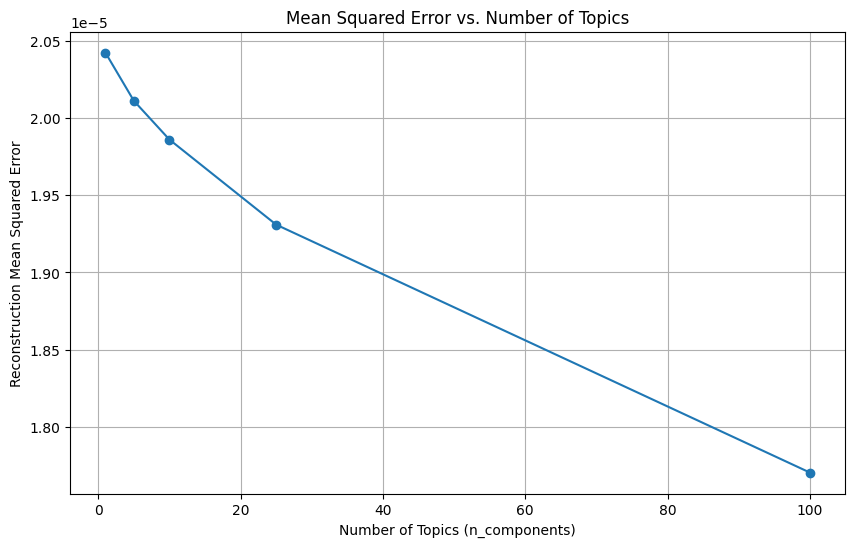

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(n_topics_results['n_components'], n_topics_results['error'], marker='o', linestyle='-')
plt.xlabel('Number of Topics (n_components)')
plt.ylabel('Reconstruction Mean Squared Error')
plt.title('Mean Squared Error vs. Number of Topics')
plt.grid(True)
plt.show()

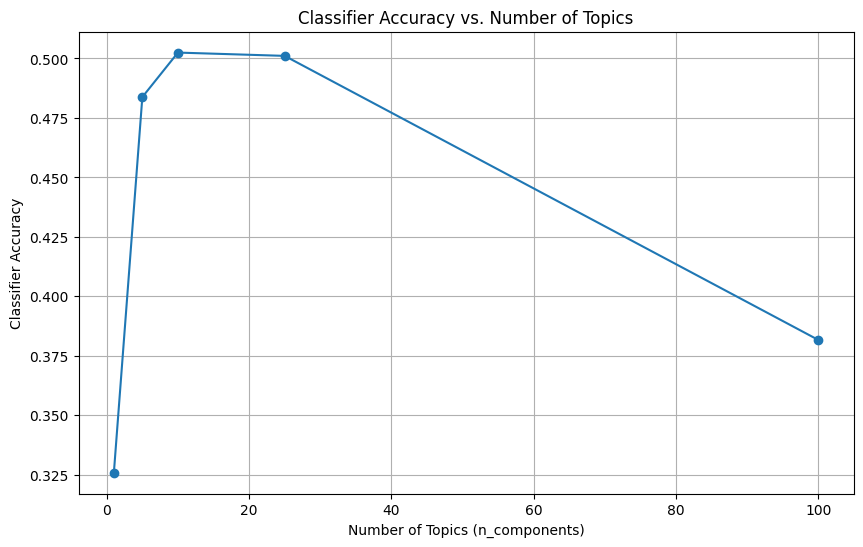

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(n_topics_results['n_components'], n_topics_results['accuracy'], marker='o', linestyle='-')
plt.xlabel('Number of Topics (n_components)')
plt.ylabel('Classifier Accuracy')
plt.title('Classifier Accuracy vs. Number of Topics')
plt.grid(True)
plt.show()

# Discussion and Improvements

## Insights

**Class Imbalance in Labels**

Supervised classifiers showed varying performance across different labels. This is likely due to the imbalance of particular labels in the dataset. The model's performance on underrepresented classes (like Label 2) was notably poorer when compared to better represented ones (like Label 1).

**Trade-off Between Reconstruction and Classification Performance**

With NMF, as the number of topics increased, the reconstruction error (MSE) decreased. This indicates that the model became better at approximating the original data. However, the best classification performance, when combined with a Logistic Regression classifier, was achieved at around 10 topics. This showcases a trade-off, a lower reconstruction error doesn't necessarily translate to better classification results.

## Improvement

**Address Class Imbalance**

1. Resampling: Use techniques like oversampling the minority classes or undersampling the majority classes to balance the dataset.

Adjust Class Weights: In classifiers like Logistic Regression, you can assign higher weights to underrepresented classes to make t2he model more sensitive to them. This would of been helpful with our NMF and Logistic Regression Classifier model.

**Hyperparameter Tuning with Cross-Validation**

Explore other hyperparameters of the NMF and Logistic Regression models, not just the number of topics.
Experiment with Different Models and Techniques:

Ensemble Methods: Use ensemble techniques like Random Forests or Gradient Boosted Trees. These models can often handle class imbalances better and might give improved performance.
Different Dimensionality Reduction Techniques: While NMF provides a non-negative matrix factorization, other techniques like PCA or t-SNE might yield different and potentially better results for classification.
Feature Engineering and Preprocessing:

Explore the possibility of engineering new features or transforming existing ones to make the classes more separable.
Adjust the preprocessing steps, like text tokenization, stemming, or lemmatization, to see if they affect classifier performance.
Regularization in NMF:

To avoid overfitting, especially when increasing the number of topics, consider adding regularization to the NMF. This can help in ensuring that the decomposition captures the most salient features without overfitting to noise.
Evaluation Metrics:

Given the class imbalance, consider using metrics like the Area Under the Receiver Operating Characteristic Curve (AUC-ROC) or the Area Under the Precision-Recall Curve (AUC-PR) for a more comprehensive assessment of model performance.
By systematically exploring these recommendations, you can incrementally improve the model's performance and gain a deeper understanding of the underlying data and its characteristics.